In [5]:
import sys, os, random, shutil, warnings, glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras

from keras import layers
from keras import Sequential

import cv2
import random

sns.set_style('darkgrid')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
pip install opencv-python

     ---------------------------------------- 39.5/39.5 MB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
def seed_all(value=42):
    random.seed(value)
    np.random.seed(value)
    tf.random.set_seed(value)
    os.environ['PYTHONHASHSEED'] = str(value)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
seed_all()

In [39]:
IMAGE_ROOT  = "C:/Users/Dell/Desktop/cv proj/hazelnut"

IMAGE_SIZE = (64, 64)

In [40]:
def get_subset(pathname, name=""):
    images = list()

    for fn in tqdm(glob.glob(pathname), desc=name):
        image = cv2.imread(fn, flags=cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE).astype(np.float32) / 255.0
        images.append(image)

    return np.array(images)

In [41]:
x_train = get_subset(os.path.join(IMAGE_ROOT, 'train', 'good', '*.png'), 'Train images')

Train images: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s]


In [42]:
print(x_train.shape)

(391, 64, 64, 3)


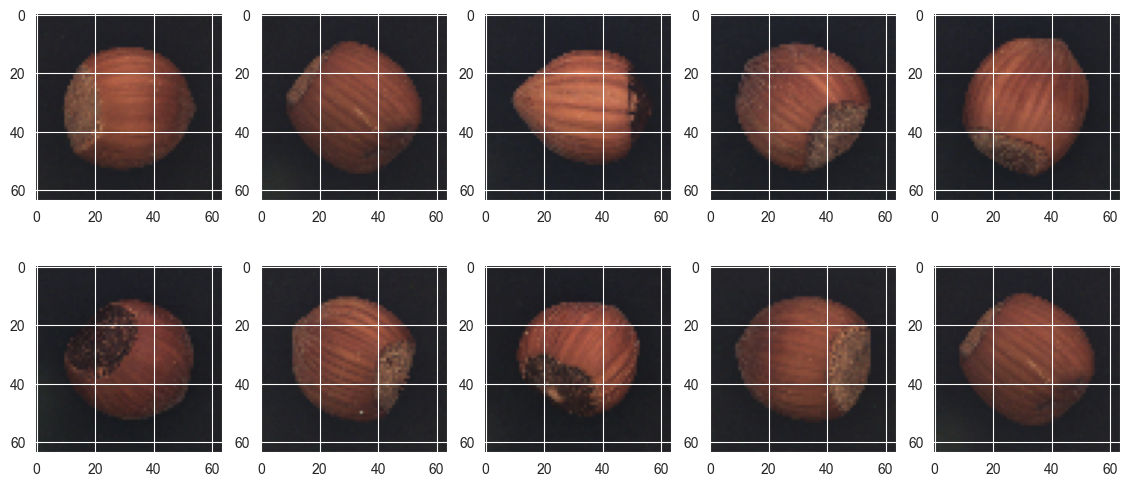

In [43]:
rows, cols = 2, 5
fig=plt.figure(figsize=(14, 6))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    image = x_train[random.randrange(x_train.shape[0])]
    plt.imshow(image)
plt.show()

In [44]:
# LATENT_DIM = 10240
# DENSE_DIM = (4, 4, 512)

def create_model(X_shape, classes=3, name="Model"):
    
    def conv_block(x, filters, *, kernels=None, steps=None, dim_transform=None, name=""):
        for i in range(len(filters)):
            x = layers.Conv2D(filters[i], kernels[i] if kernels else (3, 3), strides=steps[i] if steps else (1, 1), padding='same', name=f'{name}_conv_{i}')(x)
            x = layers.BatchNormalization(name=f'{name}_norm_{i}')(x)
            x = layers.Activation('relu', name=f'{name}_relu_{i}')(x)
        if dim_transform == 'maxpool':
            x = layers.MaxPooling2D((2, 2), name=f'{name}_maxpool')(x)
        elif dim_transform == "upsampl":
            x = layers.UpSampling2D((2, 2), name=f'{name}_upsampl')(x)
        return x
    
    inputs = x = keras.Input(X_shape[-3:], name='inputs')
    
    x = conv_block(x, (64,  ), dim_transform='maxpool', name="enc_1")
    x = conv_block(x, (128, ), dim_transform='maxpool', name="enc_2")
    x = conv_block(x, (256, ), dim_transform='maxpool', name="enc_3")
    x = conv_block(x, (512, ), dim_transform='maxpool', name="enc_4")

#     x = layers.Flatten(name="flatten")(x)
#     x = layers.Dense(LATENT_DIM, name="latent")(x)
    
#     x = layers.Dense(np.prod(DENSE_DIM), name="dec_dense")(x)
#     x = layers.Reshape(target_shape=DENSE_DIM, name="dec_reshape")(x)

    x = conv_block(x, (512, ), dim_transform='upsampl', name="dec_4")
    x = conv_block(x, (256, ), dim_transform='upsampl', name="dec_3")
    x = conv_block(x, (128, ), dim_transform='upsampl', name="dec_2")
    x = conv_block(x, (64,  ), dim_transform='upsampl', name="dec_1")

    outputs = layers.Conv2D(classes, (1, 1), activation="sigmoid", padding='same', name='ouputs')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=name)

In [45]:
model = create_model(x_train.shape, 3)

model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy'])
model.summary(line_length=110)

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                            │ (None, 64, 64, 3)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_conv_0 (Conv2D)                          │ (None, 64, 64, 64)                  │               1,792 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_norm_0 (BatchNormalization)              │ (None, 64, 64, 64)                  │                 256 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_relu_0 (Activation)                      │ (None, 64, 64, 64)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_maxpool (MaxPooling2D)                   │ (None, 32, 32, 64)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_conv_0 (Conv2D)                          │ (None, 32, 32, 128)                 │              73,856 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_norm_0 (BatchNormalization)              │ (None, 32, 32, 128)                 │                 512 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_relu_0 (Activation)                      │ (None, 32, 32, 128)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_maxpool (MaxPooling2D)                   │ (None, 16, 16, 128)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_conv_0 (Conv2D)                          │ (None, 16, 16, 256)                 │             295,168 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_norm_0 (BatchNormalization)              │ (None, 16, 16, 256)                 │               1,024 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_relu_0 (Activation)                      │ (None, 16, 16, 256)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_maxpool (MaxPooling2D)                   │ (None, 8, 8, 256)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_conv_0 (Conv2D)                          │ (None, 8, 8, 512)                   │           1,180,160 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_norm_0 (BatchNormalization)              │ (None, 8, 8, 512)                   │               2,048 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_relu_0 (Activation)                      │ (None, 8, 8, 512)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_maxpool (MaxPooling2D)                   │ (None, 4, 4, 512)                   │                   0 │
├───

 Total params: 5,467,395 (20.86 MB)

 Trainable params: 5,463,555 (20.84 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [46]:
MODEL_CHECKPOINT = f"/kaggle/working/model/{model.name}.keras"
EPOCHS = 100

callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

history = model.fit(
    x=x_train,
    y=x_train,
    epochs=EPOCHS, 
    callbacks=callbacks_list, 
    validation_split=0.2,
    verbose=1)

model.load_weights(MODEL_CHECKPOINT)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5749 - loss: 0.0641
Epoch 1: val_accuracy improved from -inf to 0.39047, saving model to /kaggle/working/model/Model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - accuracy: 0.5828 - loss: 0.0620 - val_accuracy: 0.3905 - val_loss: 0.0904
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7796 - loss: 0.0106
Epoch 2: val_accuracy did not improve from 0.39047
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.7761 - loss: 0.0105 - val_accuracy: 0.3564 - val_loss: 0.0513
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6289 - loss: 0.0050
Epoch 3: val_accuracy did not improve from 0.39047
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 0.6289 - loss: 0.0049 - val_accuracy: 0.3701 - val_loss: 0.0259
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7091 - loss: 0.0035
Epoch 4: val_accuracy improved from 0.39047 to 0.43978, saving model to /kaggle/working/model/M

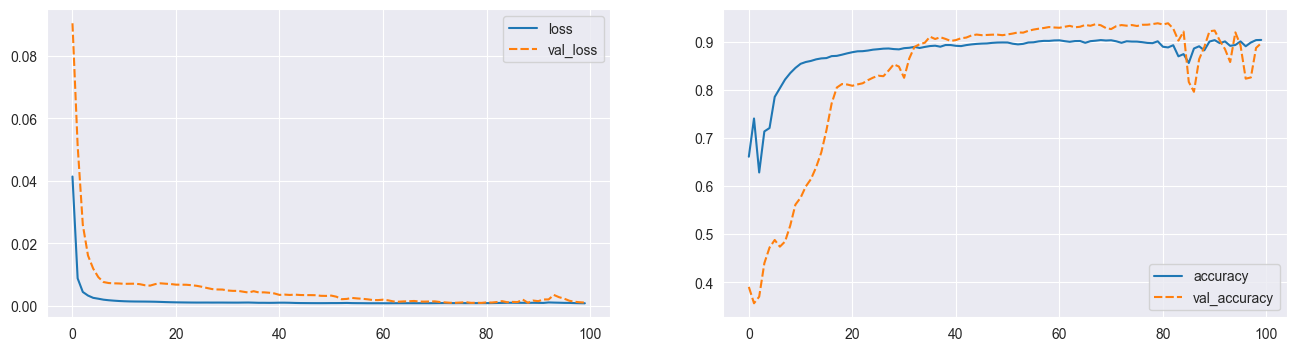

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(data={k: history.history[k] for k in ('loss', 'val_loss')}, ax=ax[0])
sns.lineplot(data={k: history.history[k] for k in history.history.keys() if k not in ('loss', 'val_loss')}, ax=ax[1])
plt.show()

good nuts: 100%|██████████| 40/40 [00:01<00:00, 32.71it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


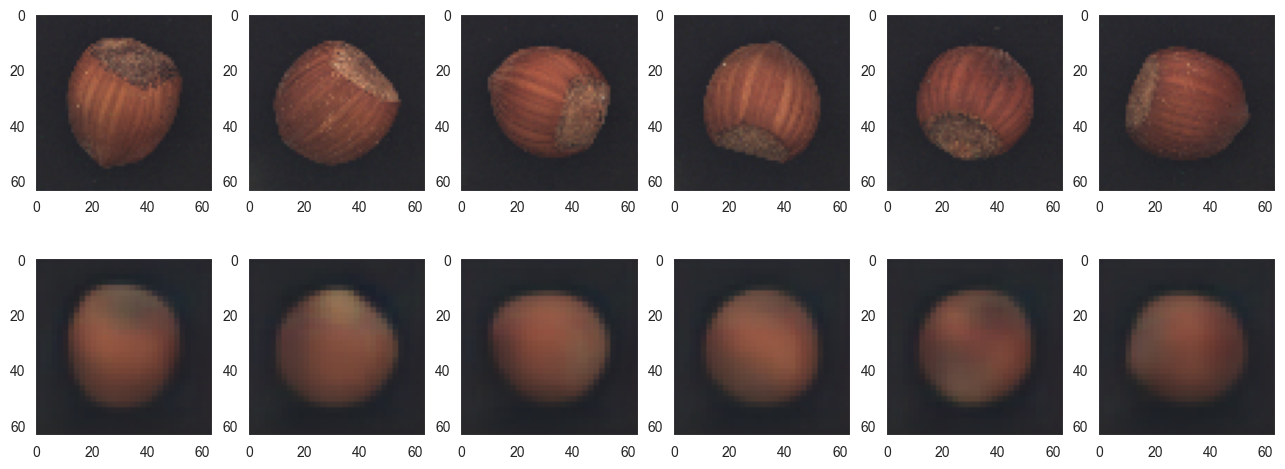

In [48]:
LABEL = 'good'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

crack nuts: 100%|██████████| 18/18 [00:00<00:00, 30.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


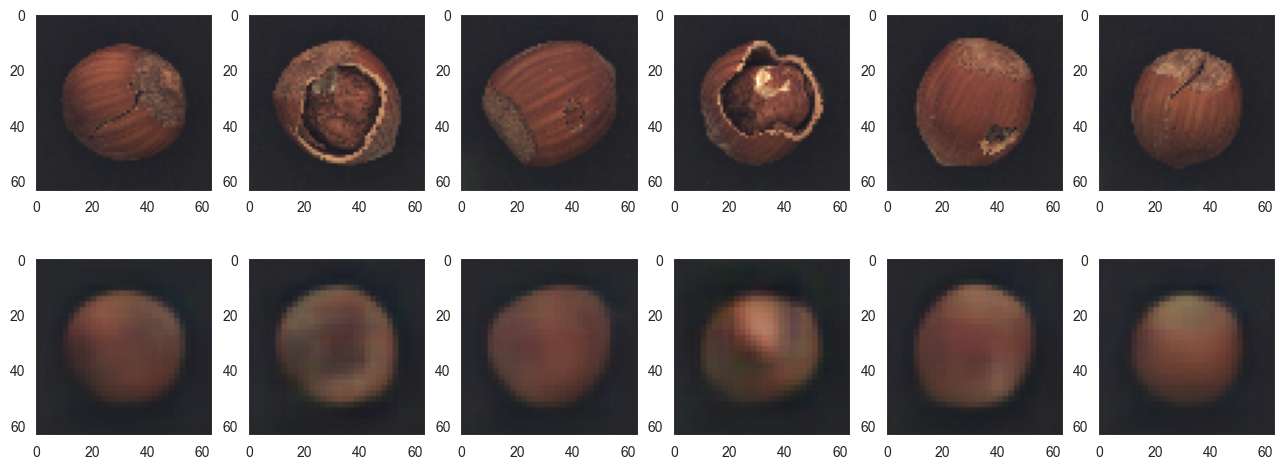

In [49]:
LABEL = 'crack'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

cut nuts: 100%|██████████| 17/17 [00:00<00:00, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


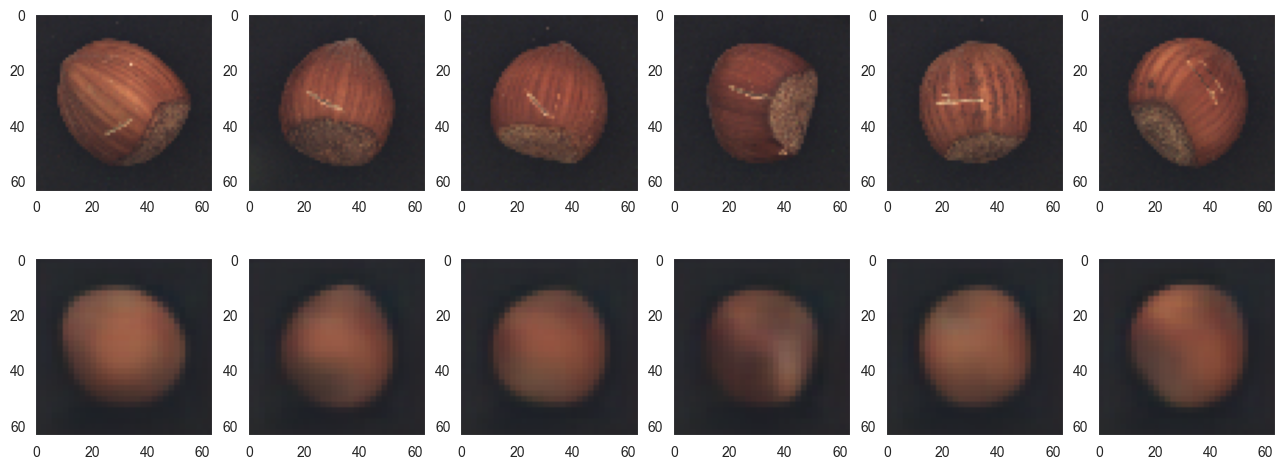

In [50]:
LABEL = 'cut'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

hole nuts: 100%|██████████| 18/18 [00:00<00:00, 31.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


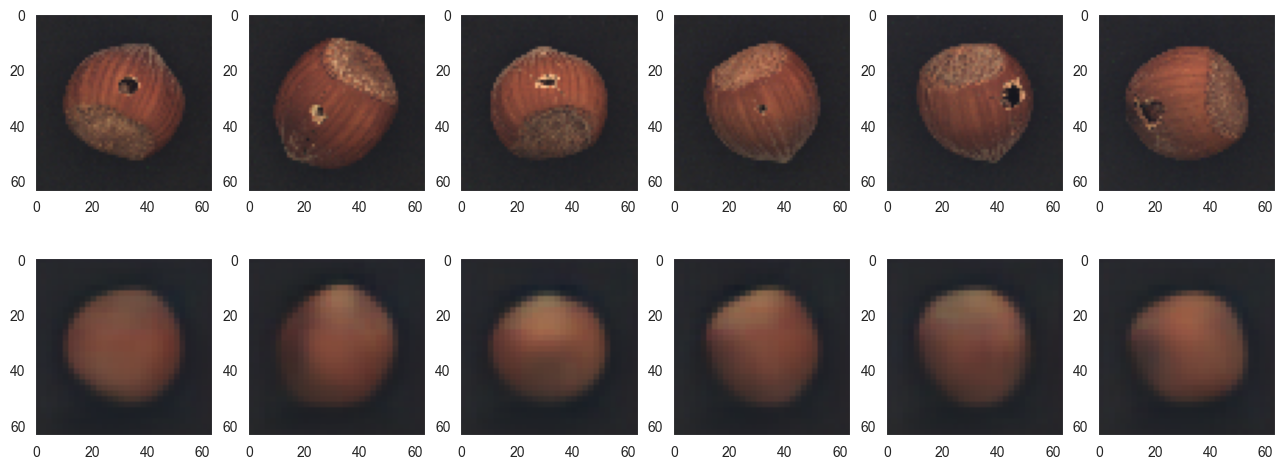

In [51]:
LABEL = 'hole'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

In [52]:
!pip install alibi-detect

     -------------------------------------- 381.5/381.5 kB 8.1 MB/s eta 0:00:00
     -------------------------------------- 443.6/443.6 kB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 119.4/119.4 kB ? eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 13.1 MB/s eta 0:00:00
     ---------------------------------------- 10.4/10.4 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 24.5/24.5 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 28.1/28.1 MB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 7.3 MB/s eta 0:00:00
     ------------------------------------- 226.8/226.8 kB 13.5 MB/s eta 0:00:00
     -------------------------------------- 315.8/315.8 kB 4.9 MB/s eta 0:00:00
     ------------------------------------- 481.4/481.4 kB 14.7 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 13.0 MB/s eta 0:00:00
     -------------------------------------- 308.9

In [53]:
from alibi_detect.od import OutlierAE

THRESHOLD = 0.005

od = OutlierAE(threshold=THRESHOLD, ae=model, data_type='image')

c:\Users\Dell\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
LABEL = 'good'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 0).sum() / len(outliers):.00%}")

good nuts: 100%|██████████| 40/40 [00:00<00:00, 47.16it/s]


Correctly predicted: 75%


cut nuts: 100%|██████████| 17/17 [00:00<00:00, 49.26it/s]


Correctly predicted: 47%


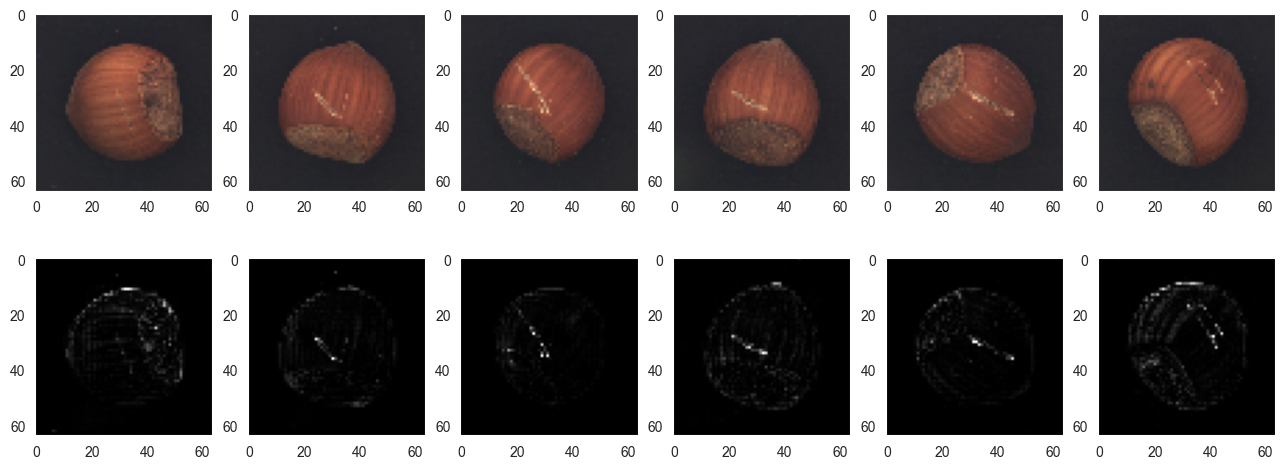

In [55]:
LABEL = 'cut'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 1).sum() / len(outliers):.00%}")

x_pred = pred['data']['feature_score']
x_pred = np.linalg.norm(x_pred, axis=-1, keepdims=True)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image, cmap='gray')

plt.show()

hole nuts: 100%|██████████| 18/18 [00:00<00:00, 47.82it/s]


Correctly predicted: 83%


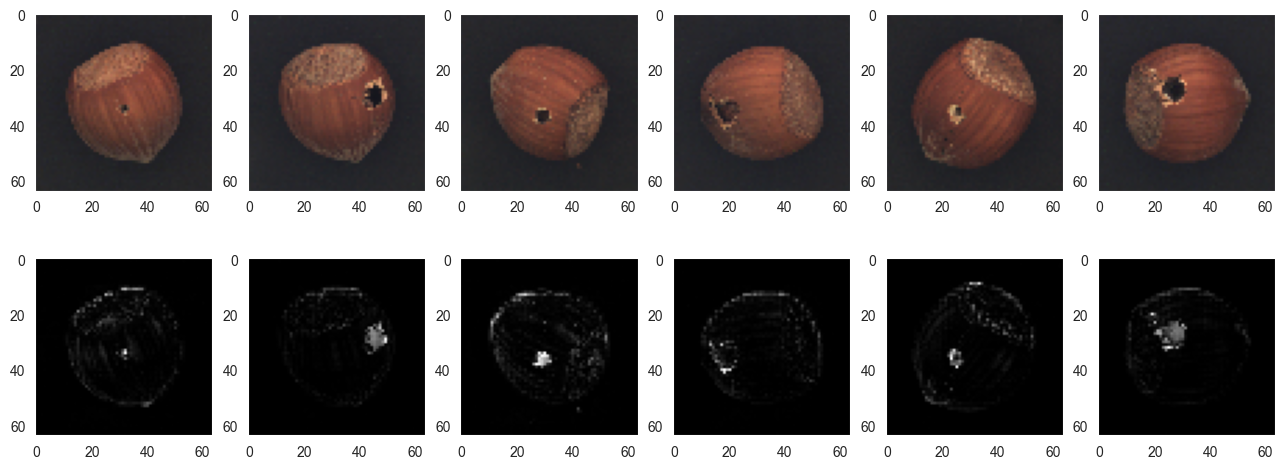

In [56]:
LABEL = 'hole'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 1).sum() / len(outliers):.00%}")

x_pred = pred['data']['feature_score']
x_pred = np.linalg.norm(x_pred, axis=-1, keepdims=True)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image, cmap='gray')

plt.show()